In [2]:
%load_ext autoreload
%autoreload 2

import mdtraj as mdt

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../analysis")
from relax import build_corrs_dict, generate_init, fit, fit_r, select_data, soe_loss


In [49]:
# xtc = "/data/gzappavigna/lmp_conf_builder/gmx/amber/step5_production_nojump.xtc"
# gro = "/data/gzappavigna/lmp_conf_builder/gmx/amber/step5_production_nojump.gro"

xtc = "/data/gzappavigna/traj/a99sb-ildn_opc/step5_production_nojump.xtc"
pdb = "/data/gzappavigna/traj/a99sb-ildn_opc/step5_production_nojump.pdb"

tot_frames = 900 * 1e3 / 0.5
n_frames = 300 * 1e3 / 0.5

traj = next(mdt.iterload(xtc, top=pdb, chunk=n_frames,skip=tot_frames-n_frames))

# traj = mdt.load(xtc, top=pdb, stride=2)

In [121]:
(traj.time[-1] - traj.time[0]) * 1e-3

299.9995

In [74]:
corrs_dict, t = build_corrs_dict(traj)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
64
65
66
67
68
69
70
71
72
73
74
76
77
78
80
81
82
83
84
85
86
87
88
89
90
91
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
123
124
125
126
127
128
129
130
131
132


In [75]:
t.size

600000

In [9]:
# from itertools import islice
# from scipy.signal import find_peaks, find_peaks_cwt

# ncols = 5
# nrows = (len(corrs_dict) + 1) // ncols
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))

# for ax, (resid, (corr, err)) in zip(axes.flat, corrs_dict.items()):
#     ind = np.argmax(corr < 0)
#     sel_t = t[:ind]
#     sel_corr = corr[:ind]

#     # inds = find_peaks(-sel_corr, prominence=1e-2, width=1e2)[0]
#     inds = find_peaks(-sel_corr, prominence=1e-3, width=1e2)[0]

#     if inds.size != 0:
#         ind = inds[0]
#         sel_t = sel_t[:ind]
#         sel_corr = sel_corr[:ind]

#     ax.semilogx(sel_t, sel_corr)
#     ax.axhline(color="k")



In [128]:
from itertools import islice

# corr, err = next(iter(corrs_dict.values()))
corr, err = next(islice(corrs_dict.values(), 71, None))
t = t[:corr.size]


mask = select_data(t, corr, err)
sel_t = t[mask]
sel_corr = corr[mask]


In [129]:
corr[1]

0.8820517964689485

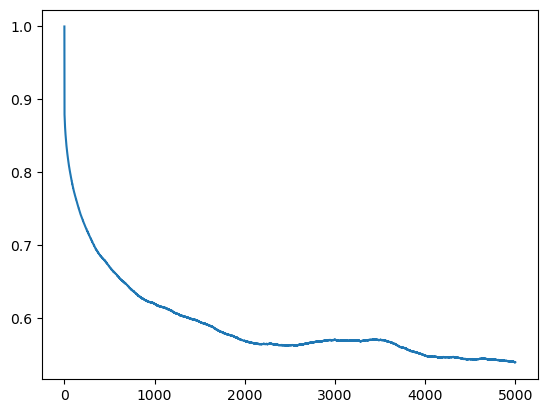

In [132]:
plt.plot(sel_t[:10000], sel_corr[:10000])

In [47]:
As, lambdas = fit_r(sel_t * 1e-3, sel_corr, [-100.0, -50.0, -0.1])

In [48]:
lambdas

array([-1.08438807e+02, -2.13374983e-02,  1.90445882e-02])

In [116]:
# see https://github.com/tenpy/tenpy/blob/d2adfe6603985852bac73afdfe8ca42354b63992/tenpy/tools/fit.py#L218-L260

def fit_with_sum_of_exp(y, n_exps):
    N = y.size
    x = np.arange(1, N + 1)
    assert n_exps < N

    F = np.zeros([N - n_exps + 1, n_exps])
    for i in range(n_exps):
        F[:, i] = y[i:i + N - n_exps + 1]

    U, _ = np.linalg.qr(F)
    U1 = U[:-1, :]
    U2 = U[1:, :]
    M = np.dot(np.linalg.pinv(U1), U2)
    lam = np.linalg.eigvals(M)
    lam = np.sort(lam)[::-1]
    # least-square fit
    W = np.power.outer(lam, x).T
    pref, *_ = np.linalg.lstsq(W, y, None)

    return lam, pref

def sum_of_exp(lambdas, prefactors, x):
    """Evaluate ``sum_i prefactor[i] * lambda[i]**x`` for different `x`.

    See :func:`fit_sum_of_exp` for more details.
    """
    return np.real_if_close(np.dot(np.power.outer(lambdas, x).T, prefactors))


start = 1000
lam, pref = fit_with_sum_of_exp(sel_corr[start:], 2)

N = sel_corr[start:].size
x = np.arange(1, N + 1)

y = sum_of_exp(lam, pref, x)


In [117]:
lam

array([ 0.99999621, -0.47113352])

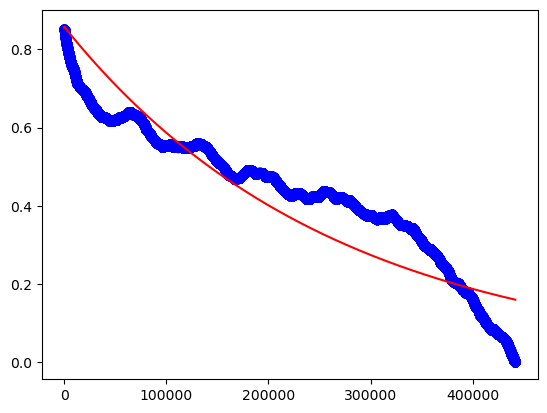

In [118]:
plt.plot(x, sel_corr[start:], "bo")
plt.plot(x, y, "r-")

In [ ]:
ncols = 5
nrows = (len(corrs_dict) + 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))

for ax, (resid, (corr, err)) in zip(axes.flat, corrs_dict.items()):
    # ax.set_xscale("log")

    # mask = select_data(t, corr, err)
    mask = t < 1e5

    sel_t = t[mask]
    sel_corr = corr[mask]
    sel_err = err[mask]

    # ax.semilogx(sel_t, sel_corr)
    ax.semilogx(sel_t, sel_err)
    # ax.plot(t, err)
    ax.axhline(color="k")


In [32]:
n0_exps = 3
fit_params = {}

chi2s = []
tmaxs = []

eps = np.finfo(float).eps
minexp = -np.finfo(float).minexp * np.log(2)


for key, (corr, err) in corrs_dict.items():
    mask = select_data(t, corr, err)

    sel_t = t[mask] #.copy()
    sel_corr = corr[mask]
    sel_err = err[mask]
    print(key)

    tmaxs.append(sel_t.max())

    # n_exps = n0_exps
    # while n_exps > 0:
    # _, lambda0s = generate_init(n0_exps)

    sel_t *= 1e-3
    # As, lambdas = fit(sel_t, sel_corr, sel_err, A0s, lambda0s)

    tau0s = np.array([50.0, 5.0, 1.0])
    lambda0s = -1.0 / tau0s

    As, lambdas = fit_r(sel_t, sel_corr, lambda0s)

    # print(lambdas)
    # taus = 1e-3 / lambdas
    taus = -1.0 / lambdas
    print(As, taus)
        # print(f"n_exps: {n_exps}")

    # TODO: if any pair of taus is close to each other repeat with less exponents
    # TODO: if any of the As is less than threshold same thing
    if taus.max() > 100 * sel_t.max():
        print("bad fit")
        continue

    x0 = np.concatenate([np.log(As), np.log(-lambdas)])
    chi2 = soe_loss(x0, np.log(sel_t + eps), sel_corr, sel_err)
    chi2s.append(chi2)

    fit_params[key] = (As, taus)
    print()
    # if key > 5:
    #     break



2
[0.15740972 0.55811149 0.13600215] [-851.37999452   44.14097886    1.53676561]

3


/tmp/ipykernel_140962/2674728962.py:45: RuntimeWarning: invalid value encountered in log
  x0 = np.concatenate([np.log(As), np.log(-lambdas)])


[0.48132523 0.31640167 0.08492884] [103.71137694  18.51206174   0.56513901]

4


R[write to console]: Error in qr.solve(M, y) : singular matrix 'a' in solve



RRuntimeError: Error in qr.solve(M, y) : singular matrix 'a' in solve


# TODO
- plot all correlations and fit functions and save a separate picture for each

0.0008080991197687908


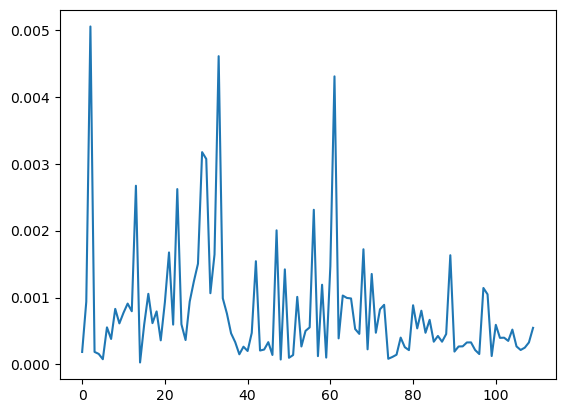

In [45]:
chi2s = np.array(chi2s)
# chi2s = chi2s[chi2s != chi2s.max()]

plt.plot(chi2s)

print(np.mean(chi2s))

# log_soe chi2: 0.0027664060425817744
# soe chi2: 0.0028363346992146456

In [46]:
np.sum(chi2s > 0.01)

0

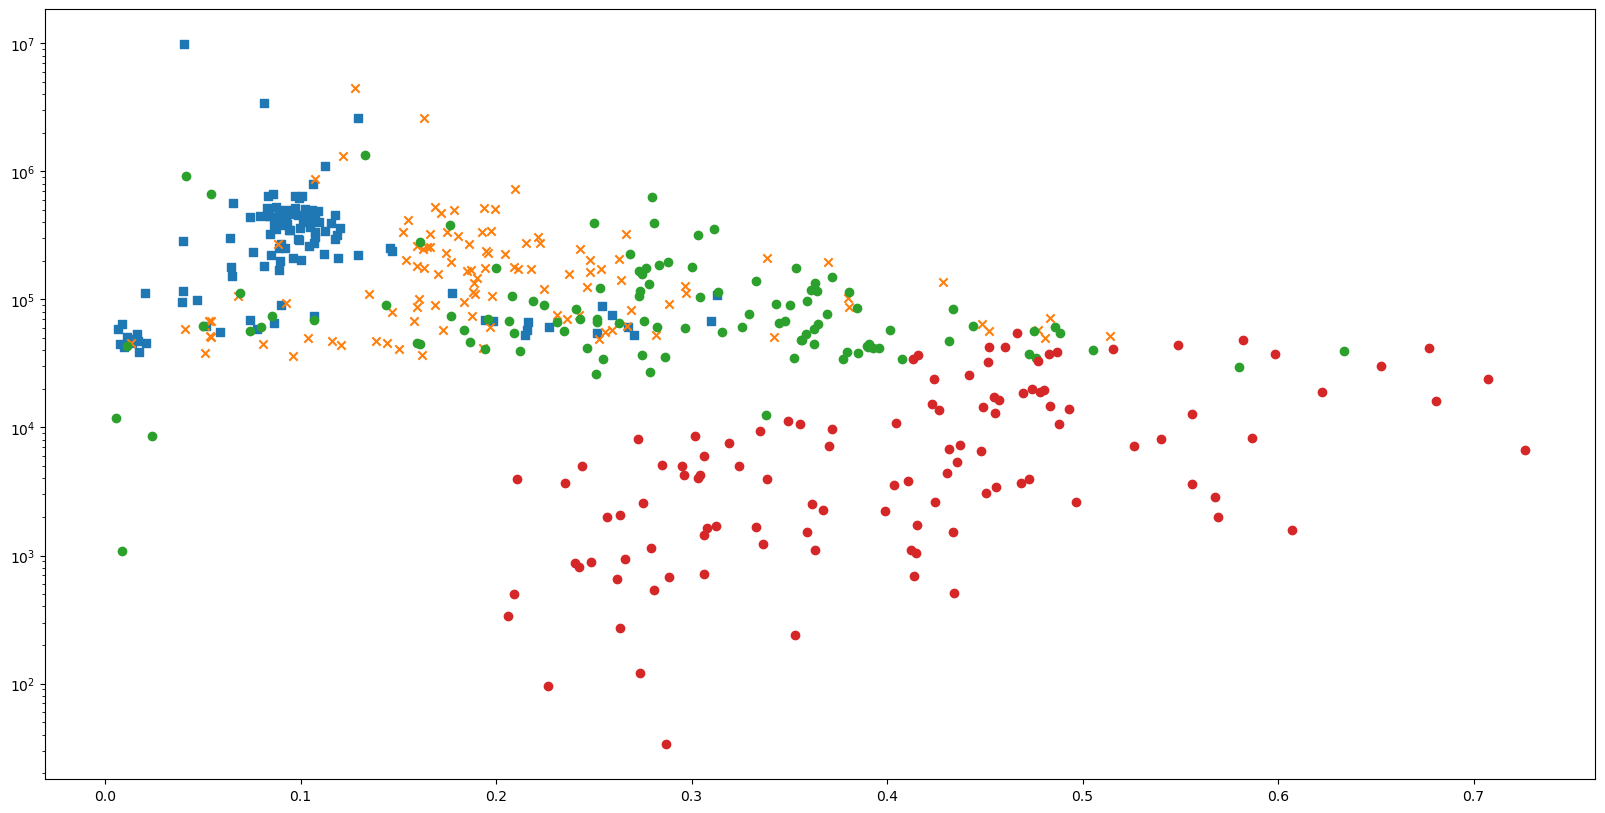

In [63]:
mask = np.array([As.size == n0_exps for As, _ in fit_params.values()])
As_taus = np.array([[As, taus] for As, taus in fit_params.values() if As.size == n0_exps])

As, taus = np.moveaxis(As_taus, 1, 0)

idx = np.argsort(-taus, axis=1)
As = np.take_along_axis(As, idx, axis=1)
taus = np.take_along_axis(taus, idx, axis=1)

plt.yscale("log")
fig = plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(10)
# plt.figure(figsize=(10, 5))

for i, m in zip(range(As.shape[1]), ["s", "x", "o", "o"]):
    plt.scatter(As[:, i], taus[:, i], marker=m, alpha=1)

In [178]:
(~mask).sum()

0

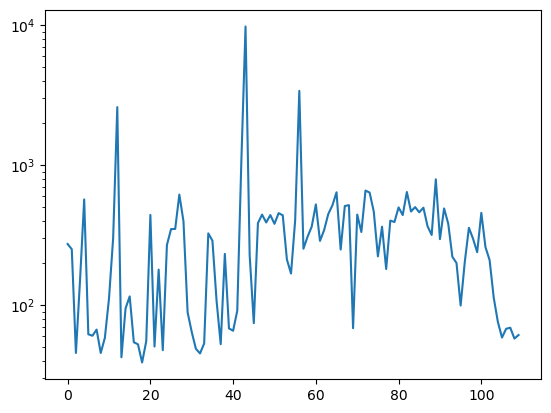

In [64]:
plt.semilogy(taus[As[:, 0] > 1e-10, 0] * 1e-3)
# plt.semilogy(As[As[:, 0] > 1e-10, 0])

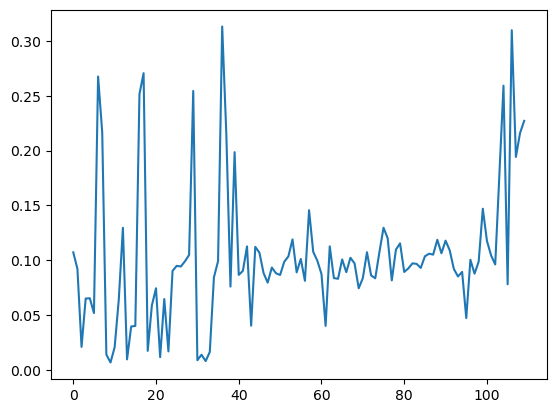

In [65]:
plt.plot(As[:, 0])

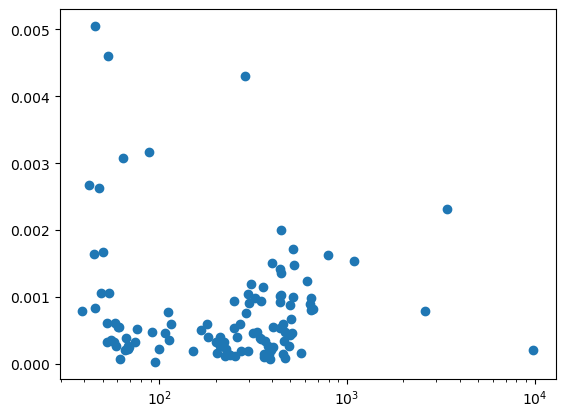

In [53]:
plt.semilogx(taus[:, 0] * 1e-3, np.array(chi2s), "o")
# plt.plot(np.array(chi2s) * 1e3)

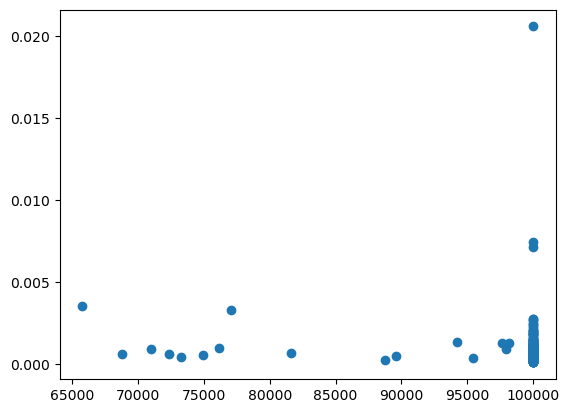

In [38]:
plt.plot(tmaxs, np.array(chi2s), "o")


In [55]:
As[:, 1][As[:, 0] < 0.2]

array([0.96097459, 0.96876248, 0.95622305, 0.90722188, 0.81659059,
       0.99990584, 0.81144289, 0.83155734, 0.85112119, 0.96712148,
       0.90618059, 0.9024039 ])

In [85]:
from nmr_relax_rates import NMR_relaxation_rates

As_taus = np.array([[As, taus] for As, taus in fit_params.values() if As.size == n0_exps])
As, taus = np.moveaxis(As_taus, 1, 0)

idx = np.argsort(-taus, axis=1)
As = np.take_along_axis(As, idx, axis=1)
taus = np.take_along_axis(taus, idx, axis=1)

rel_rates = NMR_relaxation_rates(As, taus, 850.0)


In [82]:
omegas = np.linspace(-b, b, 1000)


taus_s = taus * 1e-12

J = rel_rates.define_J(As, taus_s)

J0 = J(0)

i = 80

plt.semilogy(omegas, J(omegas)[i])
for omega in rel_rates._omegas:
    plt.vlines(omega, 0, J0[i], colors="red")

NameError: name 'b' is not defined

In [217]:
J(omegas).shape

(115, 1000)

In [218]:
taus.max()

5709208.968825851

In [219]:
rel_rates.R2.shape

(115,)

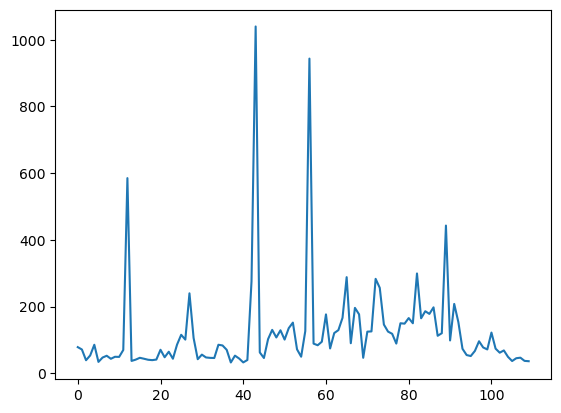

In [86]:
plt.plot(np.arange(rel_rates.R1.size), rel_rates.R2)